# DATA ACQUISITION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_csv("../input/walmart-sales/Train.csv")
test_df = pd.read_csv("../input/walmart-sales/Test.csv")

In [3]:
train_df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


**Assumptions About Impact**
* Item_Identifier-low
* Item_Weight-medium
* Item_Fat_Content-medium
* Item_Visibility-high
* Item_Type-high
* Item_MRP-medium
* Outlet_Identifier-low
* Outlet_Establishment_Year-low
* Outlet_Size-high
* Outlet_Location_Type-high
* Outlet_Type-high		

**Assumptions about sales**
1. Regular fat products have higher preference than low fat products.
2. Higher the visibility of a product to a customer, more likely is its sale.
3. Large sized stores may see more footfall and hence higher sales.
4. Stores in Tier 1 cities have higher sales due to higher income levels in that neighbourhood.
5. Supermarkets of type 1 have higher sales due to availability of vast variety of products. Grocery stores see the least sales.

**Target Variable**
* Item_Outlet_Sales

**Data Types**
* Ordinal - Outlet_Location_Type, Outlet_Size, Outlet_Establishment_Year, Item_Fat_Content
* Numerical - Item_Outlet_Sales, Item_Weight, Item_Visibility, Item_MRP
* Categorical - Outlet_Type, Item_Type
* Nominal - Item_Identifier, Outlet_Identifier 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Missing values** 
* Item_Weight
* Outlet_Size

In [5]:
for cols in train_df.columns:
    print(cols, train_df[cols].nunique())

Item_Identifier 1559
Item_Weight 415
Item_Fat_Content 5
Item_Visibility 7880
Item_Type 16
Item_MRP 5938
Outlet_Identifier 10
Outlet_Establishment_Year 9
Outlet_Size 3
Outlet_Location_Type 3
Outlet_Type 4
Item_Outlet_Sales 3493


In [6]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


* Item_Visibility being 0 does not make sense as all products must be visible to the customers. therefore consider it as a missing value.

In [7]:
train_df['Item_Identifier']

0       FDA15
1       DRC01
2       FDN15
3       FDX07
4       NCD19
        ...  
8518    FDF22
8519    FDS36
8520    NCJ29
8521    FDN46
8522    DRG01
Name: Item_Identifier, Length: 8523, dtype: object

# DATA PREPROCESSING

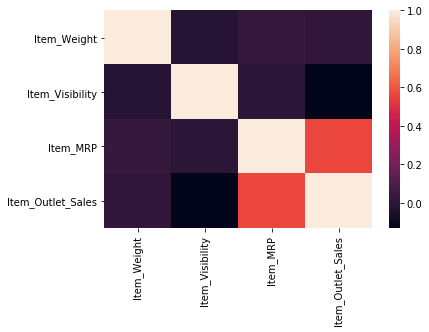

In [8]:
corr = train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP','Item_Outlet_Sales']].corr(method='pearson')
sns.heatmap(corr)

* Item_Visibility has negative correlation with Item_Outlet_Sales which is contradictory to our assumption. 
* Item_MRP has a positive correlation with target variable.

In [9]:
def relations(x):
    Outlet_Identifier_Pivot = train_df.pivot_table(index=x, values='Item_Outlet_Sales', aggfunc=np.median)
    Outlet_Identifier_Pivot.plot(kind='bar')
    plt.xlabel(x)
    plt.ylabel('Item_Outlet_Sales')
    plt.show()

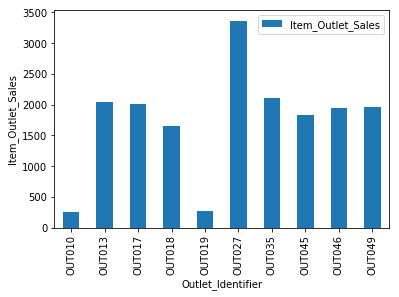

In [10]:
relations('Outlet_Identifier')

In [11]:
train_df.pivot_table(values='Outlet_Type', columns='Outlet_Identifier', aggfunc=lambda x:x.mode())

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type1,Supermarket Type2,Grocery Store,Supermarket Type3,Supermarket Type1,Supermarket Type1,Supermarket Type1,Supermarket Type1


In [12]:
train_df.pivot_table(values='Outlet_Type', columns='Outlet_Size',aggfunc=lambda x:x.mode())

Outlet_Size,High,Medium,Small
Outlet_Type,Supermarket Type1,Supermarket Type3,Supermarket Type1


* Least sales in Grocery Stores as assumed followed by Supermarket Type2.
* Strangely, Supermarket Type1 of size High have lesser sales.
* Maximum sales occur in Supermarket Type3 which are Medium sized. However, there are more Supermarket Type1 outlets.

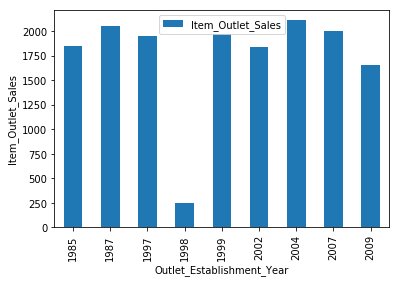

In [13]:
relations('Outlet_Establishment_Year')

* There seems to be no relation between year of establishment and outlet sales. Therefore this column can be dropped.

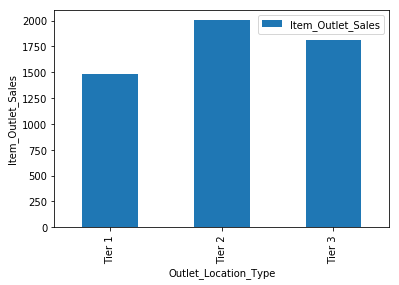

In [14]:
relations('Outlet_Location_Type')

In [15]:
train_df.pivot_table(values='Outlet_Type', columns='Outlet_Location_Type', aggfunc=lambda x:x.mode())

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Type,Supermarket Type1,Supermarket Type1,Supermarket Type3


* Our assumption that Tier 1 cities may have higher sales is proven incorrect. Highest sales occur in Tier 2 cities followed by Tier 3 cities.

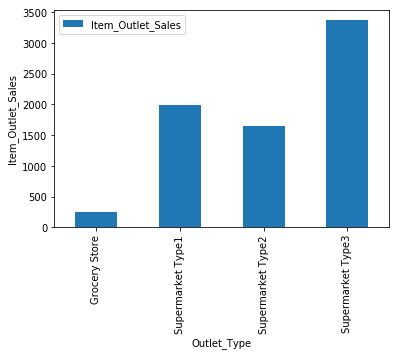

In [16]:
relations('Outlet_Type')

* Supermarket Type3 has highest sales which contradicts our assumption. Grocery Stores have the least sales which is proved.

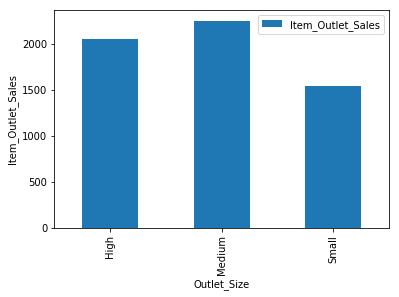

In [17]:
relations('Outlet_Size')

* Our belief that big sized stores would have higher sales does not hold true. There is a higher preference and therefore higher sales in medium sized stores. 

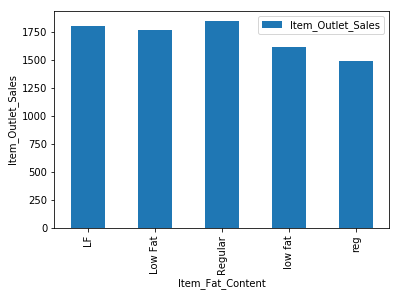

In [18]:
relations('Item_Fat_Content')

* Ideally, regular fat products should have higher sales. However, low fat products are in higher demand,

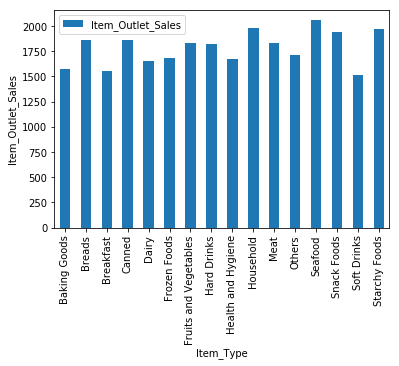

In [19]:
relations('Item_Type')

* Since there are high number of unique values, we must shrink them down into categories.

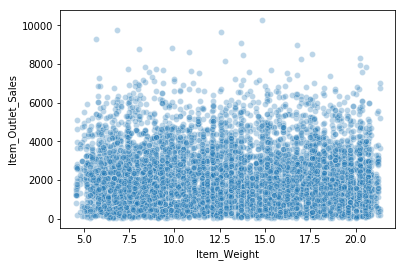

In [20]:
sns.scatterplot(data=train_df, x='Item_Weight', y='Item_Outlet_Sales', alpha=0.3)

* According to our assumption that Item_Weight has low impact on Item_Outlet_Sales, it is shown in the above plot.

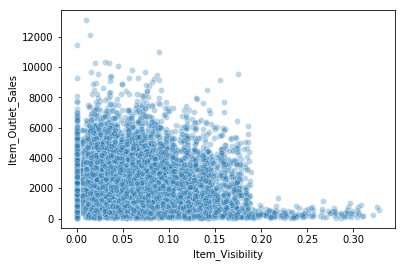

In [21]:
sns.scatterplot(data=train_df, x='Item_Visibility', y='Item_Outlet_Sales', alpha=0.3)

* Our assumption that higher the visibility, more the sales is wrong. The data shows that there is an inverse relation between them.

# FEATURE ENGINEERING

In [22]:
train_df['source']='train'
test_df['source']='test'
data = pd.concat([train_df,test_df], ignore_index = True)
print(train_df.shape, test_df.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
Item_Fat_Content             14204 non-null object
Item_Identifier              14204 non-null object
Item_MRP                     14204 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    14204 non-null object
Item_Visibility              14204 non-null float64
Item_Weight                  11765 non-null float64
Outlet_Establishment_Year    14204 non-null int64
Outlet_Identifier            14204 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Size                  10188 non-null object
Outlet_Type                  14204 non-null object
source                       14204 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 1.4+ MB


In [24]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace(['low fat', 'LF'], 'Low Fat')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace('reg', 'Regular')

In [25]:
data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=lambda x:x.mode())

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [26]:
for i in range(len(data)):
    if pd.isna(data.loc[i,'Outlet_Size']):
        if (data.loc[i,'Outlet_Type']=='Grocery Store') or (data.loc[i,'Outlet_Type']=='Supermarket Type1') :
            data.loc[i, 'Outlet_Size'] = 'Small'
        elif (data.loc[i,'Outlet_Type']=='Supermarket Type2') or (data.loc[i,'Outlet_Type']=='Supermarket Type3') :
            data.loc[i, 'Outlet_Size'] = 'Medium'

In [27]:
data['Item_Type_Category'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Category'] = data['Item_Type_Category'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
data['Item_Type_Category'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Category, dtype: int64

In [28]:
data.loc[data['Item_Type_Category']=='Non-Consumable','Item_Fat_Content'] = "Non-Edible"

In [29]:
Item_Type_Mean = data.pivot_table(columns='Item_Type', values='Item_Weight', aggfunc=lambda x:x.mean())
Item_Type_Mean

Item_Type,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods
Item_Weight,12.275211,11.152362,13.179112,12.34083,13.238358,12.569323,13.194406,11.576205,13.171739,13.337977,12.766104,13.915724,12.760274,12.865732,11.788408,13.659758


In [30]:
for i in range(len(data)):
    if pd.isna(data.loc[i, 'Item_Weight']):
        item = data.loc[i, 'Item_Type']
        data.at[i, 'Item_Weight'] = Item_Type_Mean[item]

In [31]:
Item_Visibility_Mean = data[['Item_Type_Category', 'Item_Visibility']].groupby(['Item_Type_Category'], as_index=False).mean()
Item_Visibility_Mean.columns

Index(['Item_Type_Category', 'Item_Visibility'], dtype='object')

In [32]:
for i in range(len(data)):
    if data.loc[i, 'Item_Visibility']==0:
        cat =  data.loc[i, 'Item_Type_Category']
        m = Item_Visibility_Mean.loc[Item_Visibility_Mean['Item_Type_Category'] == cat]['Item_Visibility']
        data.at[i, 'Item_Visibility'] = m

In [33]:
data['Operation_Years'] = 2013-data['Outlet_Establishment_Year']

In [34]:
data=data.drop(['Item_Type', 'Outlet_Establishment_Year'], axis=1)

In [35]:
lb=LabelEncoder()
data['Outlet']=lb.fit_transform(data['Outlet_Identifier'])
var=['Item_Fat_Content','Outlet_Location_Type','Outlet_Type','Outlet_Size','Item_Type_Category']
lb=LabelEncoder()
for item in var:
    data[item]=lb.fit_transform(data[item])
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Type','Outlet_Size','Item_Type_Category'])

In [36]:
data.head(10)

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,source,Operation_Years,Outlet,Item_Fat_Content_0,...,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Item_Type_Category_0,Item_Type_Category_1,Item_Type_Category_2
0,FDA15,249.8092,3735.1380,0.016047,9.300000,OUT049,train,14,9,1,...,0,1,0,0,0,1,0,0,1,0
1,DRC01,48.2692,443.4228,0.019278,5.920000,OUT018,train,4,3,0,...,0,0,1,0,0,1,0,1,0,0
2,FDN15,141.6180,2097.2700,0.016760,17.500000,OUT049,train,14,9,1,...,0,1,0,0,0,1,0,0,1,0
3,FDX07,182.0950,732.3800,0.068098,19.200000,OUT010,train,15,0,0,...,1,0,0,0,0,0,1,0,1,0
4,NCD19,53.8614,994.7052,0.058354,8.930000,OUT013,train,26,1,0,...,0,1,0,0,1,0,0,0,0,1
5,FDP36,51.4008,556.6088,0.068098,10.395000,OUT018,train,4,3,0,...,0,0,1,0,0,1,0,0,1,0
6,FDO10,57.6588,343.5528,0.012741,13.650000,OUT013,train,26,1,0,...,0,1,0,0,1,0,0,0,1,0
7,FDP10,107.7622,4022.7636,0.127470,12.865732,OUT027,train,28,5,1,...,0,0,0,1,0,1,0,0,1,0
8,FDH17,96.9726,1076.5986,0.016687,16.200000,OUT045,train,11,7,0,...,0,1,0,0,0,0,1,0,1,0
9,FDU28,187.8214,4710.5350,0.094450,19.200000,OUT017,train,6,2,0,...,0,1,0,0,0,0,1,0,1,0


# MODEL AND PREDICT

In [37]:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']
train = train.drop(['source'], axis=1)
test = test.drop(['source'], axis=1)

In [38]:
train.columns, test.columns, train.shape, test.shape

(Index(['Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales', 'Item_Visibility',
        'Item_Weight', 'Outlet_Identifier', 'Operation_Years', 'Outlet',
        'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2',
        'Outlet_Location_Type_0', 'Outlet_Location_Type_1',
        'Outlet_Location_Type_2', 'Outlet_Type_0', 'Outlet_Type_1',
        'Outlet_Type_2', 'Outlet_Type_3', 'Outlet_Size_0', 'Outlet_Size_1',
        'Outlet_Size_2', 'Item_Type_Category_0', 'Item_Type_Category_1',
        'Item_Type_Category_2'],
       dtype='object'),
 Index(['Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales', 'Item_Visibility',
        'Item_Weight', 'Outlet_Identifier', 'Operation_Years', 'Outlet',
        'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2',
        'Outlet_Location_Type_0', 'Outlet_Location_Type_1',
        'Outlet_Location_Type_2', 'Outlet_Type_0', 'Outlet_Type_1',
        'Outlet_Type_2', 'Outlet_Type_3', 'Outlet_Size_0', 'Outlet_Size_1',
        'O

In [39]:
data_temp = train.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
x_train = train.drop(['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'], axis=1)
y_train = train['Item_Outlet_Sales']
x_test = test.drop(['Item_Outlet_Sales','Item_Identifier', 'Outlet_Identifier'], axis=1)

x_train.shape, y_train.shape, x_test.shape

((8523, 21), (8523,), (5681, 21))

In [40]:
x_train.columns, x_test.columns

(Index(['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Operation_Years',
        'Outlet', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
        'Item_Fat_Content_2', 'Outlet_Location_Type_0',
        'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Type_0',
        'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3', 'Outlet_Size_0',
        'Outlet_Size_1', 'Outlet_Size_2', 'Item_Type_Category_0',
        'Item_Type_Category_1', 'Item_Type_Category_2'],
       dtype='object'),
 Index(['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Operation_Years',
        'Outlet', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
        'Item_Fat_Content_2', 'Outlet_Location_Type_0',
        'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Type_0',
        'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3', 'Outlet_Size_0',
        'Outlet_Size_1', 'Outlet_Size_2', 'Item_Type_Category_0',
        'Item_Type_Category_1', 'Item_Type_Category_2'],
       dtype='object'))

In [41]:
def model_prediction(algo):
    model = algo
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc= round(model.score(x_train,y_train) * 100,2)
    output = pd.DataFrame({'Item_Identifier':test['Item_Identifier'], 'Outlet_Identifier':test['Outlet_Identifier'], 'Item_Outlet_Sales':y_pred}, columns=['Item_Identifier','Outlet_Identifier', 'Item_Outlet_Sales'])
    return acc, output

In [42]:
model = LinearRegression()
linreg_acc, linreg_output = model_prediction(model)
linreg_acc

56.35

In [43]:
model = RandomForestRegressor(n_estimators=200, max_depth=5,min_samples_leaf=100, n_jobs=4)
forestreg_acc, forestreg_output = model_prediction(model)
forestreg_acc

60.45

In [44]:
train_set, test_set = train_test_split(data_temp, test_size = 0.2)
x_train_temp = train_set.drop(['Item_Outlet_Sales'], axis=1)
y_train_temp = train_set['Item_Outlet_Sales']
x_test_temp = test_set.drop(['Item_Outlet_Sales'], axis=1)
y_test_temp = test_set['Item_Outlet_Sales']

scaler = MinMaxScaler(feature_range=(0,1))
x_train_scaled = scaler.fit_transform(x_train_temp)
x_train_temp = pd.DataFrame(x_train_scaled)
x_test_scaled = scaler.fit_transform(x_test_temp)
x_test_temp = pd.DataFrame(x_test_scaled)

x_train_temp.shape, y_train_temp.shape, x_test_temp.shape, y_test_temp.shape

((6818, 21), (6818,), (1705, 21), (1705,))

RMSE value for k=  1 is: 1538.676112820663
RMSE value for k=  2 is: 1337.0110890451074
RMSE value for k=  3 is: 1242.2078075593934
RMSE value for k=  4 is: 1201.6043728570241
RMSE value for k=  5 is: 1167.6047967421919
RMSE value for k=  6 is: 1154.302188417941
RMSE value for k=  7 is: 1141.1051860309376
RMSE value for k=  8 is: 1133.538851183626
RMSE value for k=  9 is: 1118.42613779751
RMSE value for k=  10 is: 1110.805610370521
RMSE value for k=  11 is: 1111.55594125839
RMSE value for k=  12 is: 1109.0714847291051
RMSE value for k=  13 is: 1108.441462788009
RMSE value for k=  14 is: 1105.3537005097328
RMSE value for k=  15 is: 1104.6157588652527


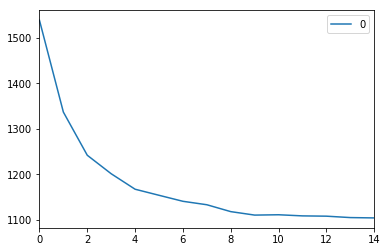

In [45]:
rmse=[]
for k in range(15):
    k = k+1
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(x_train_temp, y_train_temp)
    y_pred_temp=model.predict(x_test_temp) 
    error = np.sqrt(mean_squared_error(y_test_temp,y_pred_temp))
    rmse.append(error)
    print('RMSE value for k= ' , k , 'is:', error)
    
curve = pd.DataFrame(rmse)
curve.plot()

In [46]:
model=KNeighborsRegressor(n_neighbors=11)
knr_acc, knr_output = model_prediction(model)
knr_acc

62.71

In [47]:
model = Ridge(alpha=0.05, normalize=True)
ridge_acc, ridge_output = model_prediction(model)
ridge_acc

56.11

# RESULTS

In [48]:
model_acc_list = [['Linear Regression', linreg_acc], ['Random Forest Regressor', forestreg_acc], ['K Neighbors Regressor', knr_acc], ['Ridge Regression', ridge_acc]]
model_acc_df = pd.DataFrame(data=model_acc_list, columns=['Model', 'Accuracy'])
model_acc_df

,Model,Accuracy
0,Linear Regression,56.35
1,Random Forest Regressor,60.45
2,K Neighbors Regressor,62.71
3,Ridge Regression,56.11
